# ARIMA Model – Complete Guide to Time Series Forecasting in Python

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [22]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

# Principle Informations
SARIMA(p,d,q)x(P,D,Q)
An ARIMA model is characterized by 3 terms: p, d, q where,
* p is the order of the AR term ("Auto Regressive"; p ist Anzahl der Inkremente der Messung, die zum Schätzen benutzt werden.)
* q is the order of the MA term ("Moving Average" ; q ist die Ordnung des MA-Terms und bezieht sich auf der verzögerten Vohrhersagefehler die ins Modell einfließen.)
* d is the number of differencing required to make the time series stationary (Stationarität notwendig, da ARIMA die Vergangenheit der Zeitreihe nutzt zur Vorhersage (Autoregression) und lineare Regressionsmodelle a, besten funktionieren, wennn die Schätzer nicht korreliert und unabhängig von einander sind.)
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

>___ARIMA model in words:___ Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

$\alpha$ is the intercept term

## How to determine ___d___
>___Achtung:___ Nicht überdifferenzieren!!!
* ACF-Plot muss schnell zu Null konvergieren
* Mittelwert muss nahzu konstant sein
* Im Zweifelsfall die Ordnung mit der kleinsten Standardverteilung in der differenzierten Serie.

>___Tipp:___
- Wenn die Reihe leicht unterdifferenziert ist, kann dies in der Regel durch Hinzufügen eines oder mehrerer zusätzlicher AR-Terme ausgeglichen werden. 
- Wenn sie leicht überdifferenziert ist, hilft einen zusätzlichen MA-Term hinzufügen.

### Erstmal Stationaritätstests
Z:B. Augmented Dickey-Fuller

In [23]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Da p>0.05 (Signifikanzlevel) Differenzierung notwendig

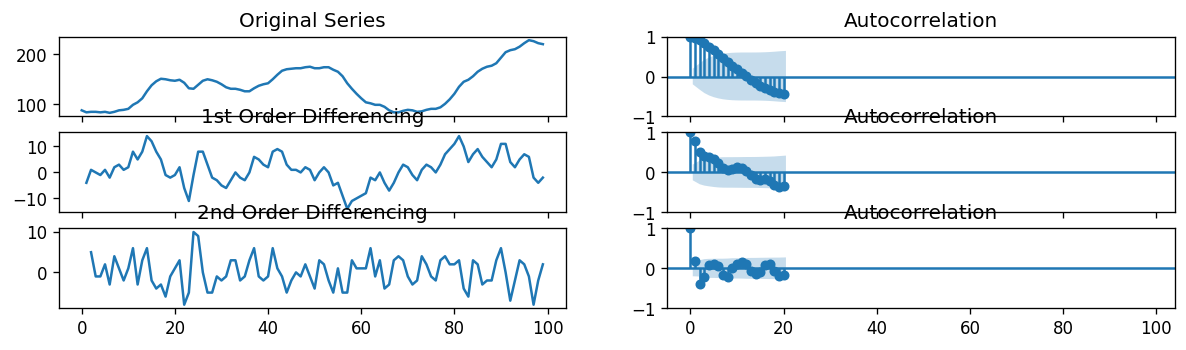

In [24]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

>___Achtung:___ Nach zweifacher Differenzierung geht die Autokorrelation sofort ins Negative --> ***Überdifferenziert!!!*** D.h. d=1

In [25]:
# Einfache Differenzierung und drei unterschiedliche stationaritätstests
## Adf Test
#ndiffs(y, test='adf')  # 2

# KPSS test
#ndiffs(y, test='kpss')  # 0

# PP test:
#ndiffs(y, test='pp')  # 2

## Ermitteln des p-Werts

Jede Autokorrelation in einer stationären Reihe kann durch Hinzufügen einer ausreichenden Anzahl von AR-Termen ***korrigiert*** werden. 

Daher nehmen wir zunächst an, dass die Ordnung des AR-Terms gleich der Anzahl der Lags ist, die ___die Signifikanzgrenze im PACF-Diagramm überschreitet___.

Da im Beispiel Lag2 nur noch leicht über der Signifikanzgrenze liegt, nehmen wir vorsichtshalber doch p=1.

/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


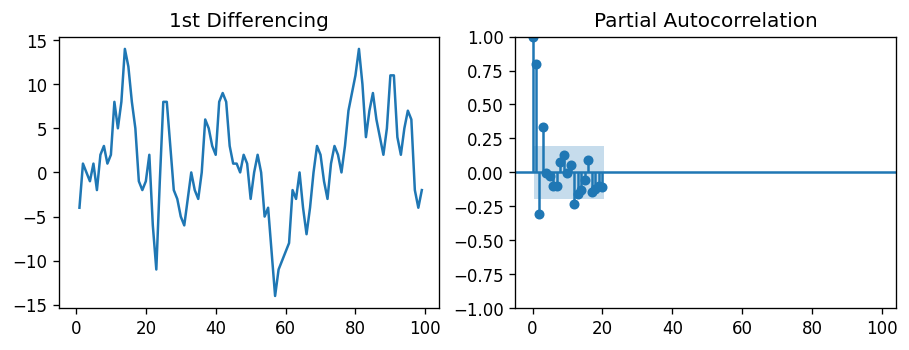

In [26]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

## Ermitteln des q-Werts

Ähnlich wie beim p-Wert nur mit Autokorrelationsplot, MA-Term technisch der Fehler der verzögerten Vorhersage ist.

Im Zweifelsfall sollte man sich für das einfachere Modell entscheiden, das Y ausreichend erklärt; qlso q=2.

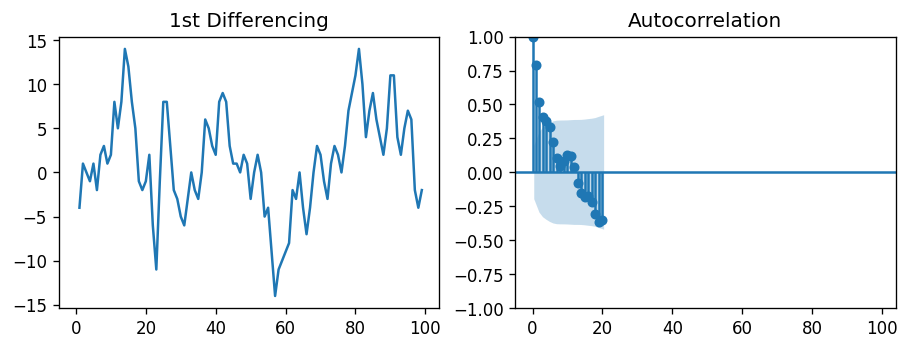

In [28]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

# Modeling mit ARIMA

In [33]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Fri, 20 May 2022   AIC                            516.253
Time:                        10:50:20   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

# Wichiger Hinweis für Sarima
SARIMA(p,d,q)x(P,D,Q), wobei P, D und Q SAR, die Ordnung der saisonalen Differenzierung bzw. SMA-Terme sind und "x" die Frequenz der Zeitreihe ist.

Wenn Ihr Modell gut definierte saisonale Muster aufweist, dann erzwingen Sie D=1 für eine bestimmte Häufigkeit 'x'.

In der Regel sollten Sie die Modellparameter so einstellen, dass D nie größer als eins ist. Und die Gesamtdifferenzierung 'd + D' überschreitet nie 2. Versuchen Sie, nur entweder SAR- oder SMA-Terme beizubehalten, wenn Ihr Modell saisonale Komponenten aufweist.

In [ ]:
#Beispiel
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, 
                        start_p=1,
                        max_p=3, 
                        start_q=1, 
                        max_q=3,
                        test='adf', 
                        m=12,           # Frequenz, bzw. Periode alle 12 Zeilen
                        start_P=0, 
                        seasonal=True,
                        d=None, 
                        D=1, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

smodel.summary()